**BDP Assignment 6**

**ID: 202318009**

**Name: ANMOL POONIA**

In [ ]:
# installing pyspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=63b23028959b24fa2bf4951474a0880ff934af06c73b6a5bef1230bb286b3aea
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# importing libraries and datasets

from sklearn.datasets import fetch_20newsgroups

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import numpy as np

from pyspark.ml.clustering import KMeans,  BisectingKMeans
from pyspark.ml.feature import Tokenizer, IDF, HashingTF

from pyspark.ml import Pipeline

import matplotlib.pyplot as plt

from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
# creating spark session

spark = SparkSession.builder.appName("Clustering").master("local").getOrCreate()
spark

In [ ]:
data = fetch_20newsgroups()
data = data['data']

# creating spark dataframe from news data
df = spark.createDataFrame([(text,) for text in data], ["text"])
df.show()

+--------------------+
|                text|
+--------------------+
|From: lerxst@wam....|
|From: guykuo@cars...|
|From: twillis@ec....|
|From: jgreen@ambe...|
|From: jcm@head-cf...|
|From: dfo@vttoulu...|
|From: bmdelane@qu...|
|From: bgrubb@dant...|
|From: holmes7000@...|
|From: kerr@ux1.cs...|
|From: irwin@cmptr...|
|From: david@termi...|
|From: rodc@fc.hp....|
|From: dbm0000@tm0...|
|From: jllee@acsu....|
|From: mathew <mat...|
|From: ab@nova.cc....|
|From: CPKJP@vm.cc...|
|From: ritley@uimr...|
|From: abarden@tyb...|
+--------------------+
only showing top 20 rows



In [ ]:
# tokenizing text lines into words

tokenizer = Tokenizer(inputCol="text", outputCol="words")
words = tokenizer.transform(df)

tokenizer, words.show()

+--------------------+--------------------+
|                text|               words|
+--------------------+--------------------+
|From: lerxst@wam....|[from:, lerxst@wa...|
|From: guykuo@cars...|[from:, guykuo@ca...|
|From: twillis@ec....|[from:, twillis@e...|
|From: jgreen@ambe...|[from:, jgreen@am...|
|From: jcm@head-cf...|[from:, jcm@head-...|
|From: dfo@vttoulu...|[from:, dfo@vttou...|
|From: bmdelane@qu...|[from:, bmdelane@...|
|From: bgrubb@dant...|[from:, bgrubb@da...|
|From: holmes7000@...|[from:, holmes700...|
|From: kerr@ux1.cs...|[from:, kerr@ux1....|
|From: irwin@cmptr...|[from:, irwin@cmp...|
|From: david@termi...|[from:, david@ter...|
|From: rodc@fc.hp....|[from:, rodc@fc.h...|
|From: dbm0000@tm0...|[from:, dbm0000@t...|
|From: jllee@acsu....|[from:, jllee@acs...|
|From: mathew <mat...|[from:, mathew, <...|
|From: ab@nova.cc....|[from:, ab@nova.c...|
|From: CPKJP@vm.cc...|[from:, cpkjp@vm....|
|From: ritley@uimr...|[from:, ritley@ui...|
|From: abarden@tyb...|[from:, ab

(Tokenizer_3cf9b949cad9, None)

In [ ]:
# converting tokenized data into tf-idf vector

hashing_tf = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

model = idf.fit(hashing_tf.transform(words))
tfidf = model.transform(hashing_tf.transform(words))

tfidf.select('features').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:

# converting features of tf-idf vector i.e. sparse vector of mllib into numpy array and parellelizing with rdd
tfidf_features = tfidf.select("features").rdd.flatMap(lambda x: np.array(x[0].toArray()))

df = tfidf.select('features').toPandas()
df['features'] = df['features'].apply(lambda x: np.array(x.toArray()))
df

,features
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.964436705600616, 0..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
11309,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.78853489..."
11310,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11311,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11312,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# Perform K-means clustering

kmeans = KMeans(k=10)
kmeans = kmeans.fit(tfidf)
kmeans_pred = kmeans.transform(tfidf)

kmeans_pred.show()

+--------------------+--------------------+--------------------+--------------------+----------+
|                text|               words|         rawFeatures|            features|prediction|
+--------------------+--------------------+--------------------+--------------------+----------+
|From: lerxst@wam....|[from:, lerxst@wa...|(10000,[187,476,4...|(10000,[187,476,4...|         0|
|From: guykuo@cars...|[from:, guykuo@ca...|(10000,[94,170,27...|(10000,[94,170,27...|         0|
|From: twillis@ec....|[from:, twillis@e...|(10000,[5,66,157,...|(10000,[5,66,157,...|         0|
|From: jgreen@ambe...|[from:, jgreen@am...|(10000,[51,145,30...|(10000,[51,145,30...|         0|
|From: jcm@head-cf...|[from:, jcm@head-...|(10000,[11,145,30...|(10000,[11,145,30...|         0|
|From: dfo@vttoulu...|[from:, dfo@vttou...|(10000,[10,36,66,...|(10000,[10,36,66,...|         0|
|From: bmdelane@qu...|[from:, bmdelane@...|(10000,[55,94,263...|(10000,[55,94,263...|         0|
|From: bgrubb@dant...|[from:, 

In [ ]:
# Perform Hierarchical clustering (Bisecting K-means)

hierarchical = BisectingKMeans(k=10 )
hierarchical = hierarchical.fit(tfidf)
hierarchical_pred = hierarchical.transform(tfidf)

hierarchical_pred.show()

+--------------------+--------------------+--------------------+--------------------+----------+
|                text|               words|         rawFeatures|            features|prediction|
+--------------------+--------------------+--------------------+--------------------+----------+
|From: lerxst@wam....|[from:, lerxst@wa...|(10000,[187,476,4...|(10000,[187,476,4...|         0|
|From: guykuo@cars...|[from:, guykuo@ca...|(10000,[94,170,27...|(10000,[94,170,27...|         0|
|From: twillis@ec....|[from:, twillis@e...|(10000,[5,66,157,...|(10000,[5,66,157,...|         0|
|From: jgreen@ambe...|[from:, jgreen@am...|(10000,[51,145,30...|(10000,[51,145,30...|         0|
|From: jcm@head-cf...|[from:, jcm@head-...|(10000,[11,145,30...|(10000,[11,145,30...|         0|
|From: dfo@vttoulu...|[from:, dfo@vttou...|(10000,[10,36,66,...|(10000,[10,36,66,...|         1|
|From: bmdelane@qu...|[from:, bmdelane@...|(10000,[55,94,263...|(10000,[55,94,263...|         0|
|From: bgrubb@dant...|[from:, 

In [ ]:
# estimating cost of Within-Cluster Sum of Squares (WCSS)

wcss = []

features = tfidf.select('features')
for k in range(2, 21):
    kmeans = KMeans(k=k)
    model = kmeans.fit(features)
    wcss.append(model.summary.trainingCost)


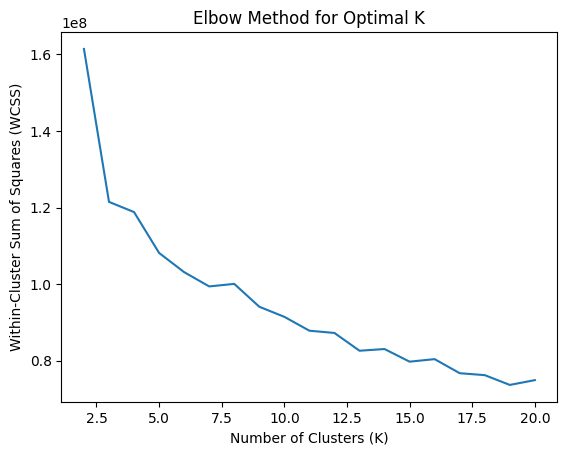

In [ ]:
# Elbow method to find value of K

plt.plot(range(2, 21), wcss)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()


**Here optimal value of K is 7 as elbow is created at k = 7**

In [ ]:
# Define maximum number of clusters
max_clusters = 20

# Create hierarchical clustering object (BisectingKMeans for bottom-up simulation)
hclust = BisectingKMeans(k=2, distanceMeasure="euclidean")  # Start with 1 cluster (all data)
wcss2 = []

# Use a loop to iteratively split clusters until max_clusters is reached, simulating bottom-up
cluster_history = [tfidf.select('features')]
for i in range(2, max_clusters + 1):
    model = hclust.fit(cluster_history[-1].select('features'))
    cluster_history.append(model.transform(cluster_history[-1].select('features')))
    wcss2.append(model.summary.trainingCost)


In [ ]:
# plotting dendrogram for hierarchical clustering

from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


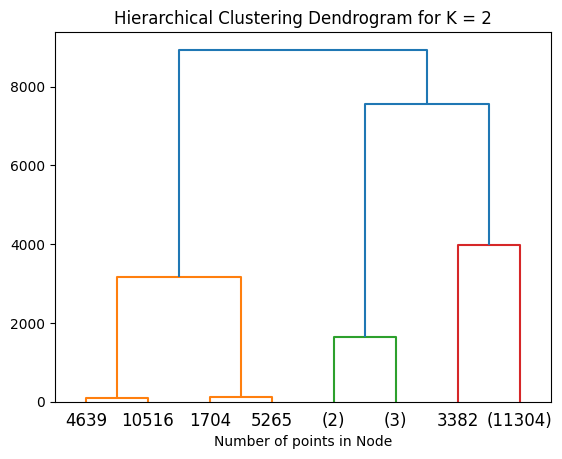

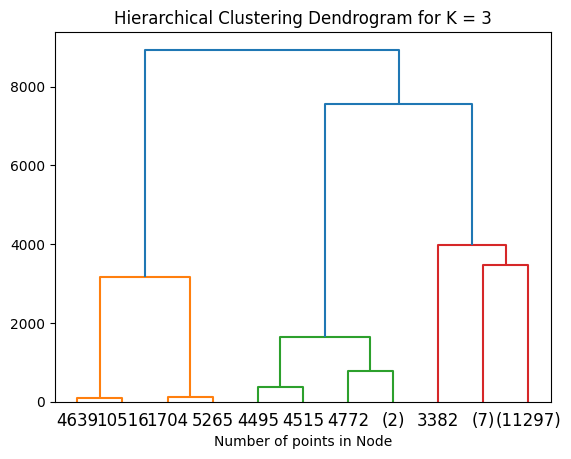

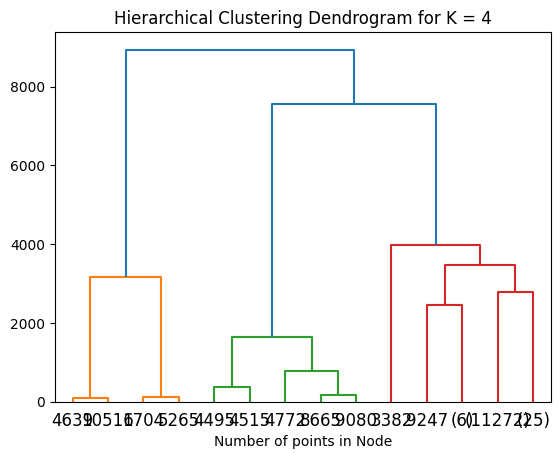

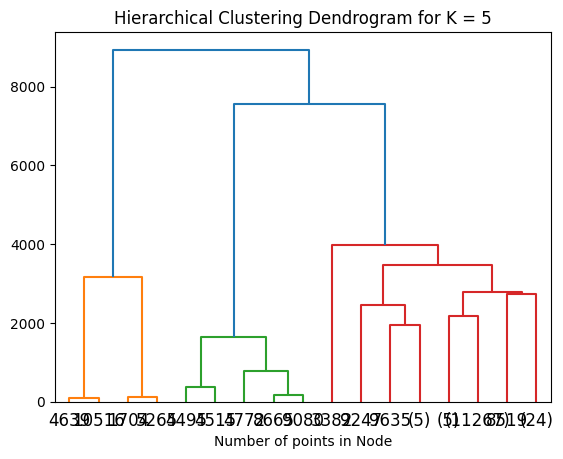

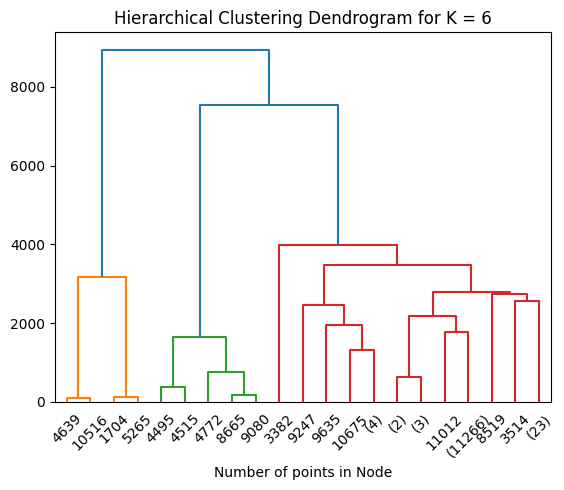

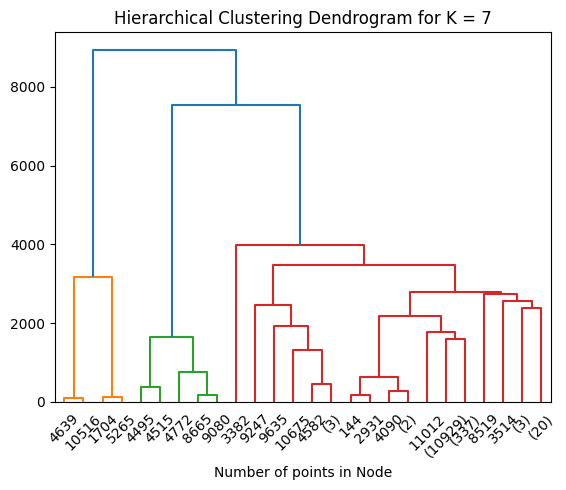

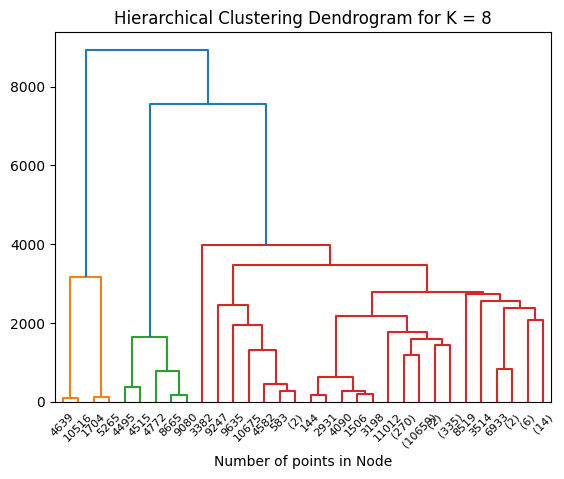

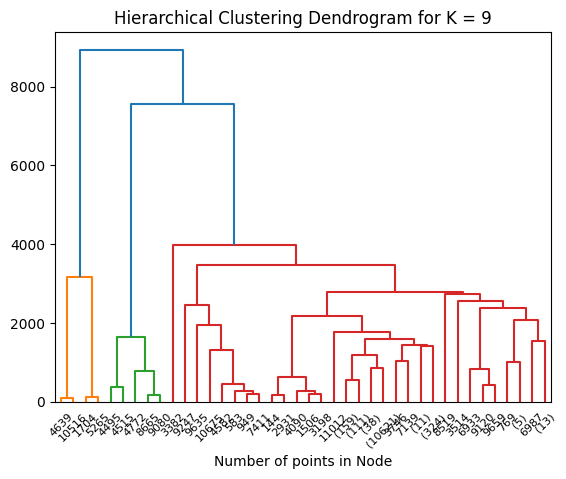

In [ ]:
# plotting clusters with different values of K

from sklearn.cluster import AgglomerativeClustering

list1 = []

for i in range(len(df)):
  list1.append(df.iloc[i, 0])

final_matrix = np.array(list1)
final_matrix.shape

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(final_matrix)

for k in range(2, 10):

  plt.title(f"Hierarchical Clustering Dendrogram for K = {k}")

  # plot the top three levels of the dendrogram
  plot_dendrogram(model, truncate_mode="level", p=k)
  plt.xlabel("Number of points in Node")
  plt.show()
  print()


**Here optimal number of clusters is 4 for hierarchical clustering**